#### STOCK MARKET PRICE FORCASTING USING STACKED LSTM (LONG SHORT TERM MEMORY)

In this project LSTM model is trained and tested on last 7 years of real time date of TATAMOTORS company stocks. 

In [10]:
#Importing the libraries
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt


#### 1. Data collection

In this step data is called from the yahoo finance site using the below API.<br>
Data from 2015 to 2022 March is collected using the below API.

In [43]:
Stock_name = 'TATAMOTORS.NS' #HDFC Bank
start_date = int(time.mktime(datetime.datetime(2015, 1 , 1 , 23, 59).timetuple()))
end_date = int(time.mktime(datetime.datetime(2022, 3 , 31 , 23, 59, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{Stock_name}?period1={start_date}&period2={end_date}&interval={interval}&events=history&includeAdjustedClose=true'
df = pd.read_csv(query_string)
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,489.252289,494.149750,487.026154,493.160370,492.960724,944551.0
1,2015-01-02,491.973083,511.909271,491.973083,506.368683,506.163696,4193093.0
2,2015-01-05,504.686737,520.417969,501.322815,518.241333,518.031555,6758676.0
3,2015-01-06,508.891632,508.891632,493.951874,496.079071,495.878235,7979598.0
4,2015-01-07,489.746979,495.089661,484.008514,488.609192,488.411377,9232656.0


### 2. Data Preparation

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790 entries, 0 to 1789
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1790 non-null   object 
 1   Open       1789 non-null   float64
 2   High       1789 non-null   float64
 3   Low        1789 non-null   float64
 4   Close      1789 non-null   float64
 5   Adj Close  1789 non-null   float64
 6   Volume     1789 non-null   float64
dtypes: float64(6), object(1)
memory usage: 98.0+ KB


In [103]:
#Dropping nullvalues
df.dropna(inplace=True)

In [104]:
#For this project I need to forcast the close price for the 30 days after the last date in the dataset. 
# So lets select only the close price column from the dataset.
Data = df['Close']
Data.head()  

0    493.160370
1    506.368683
2    518.241333
3    496.079071
4    488.609192
Name: Close, dtype: float64

In [105]:
#this data contains 1839 days of data
Data.shape

(1789,)

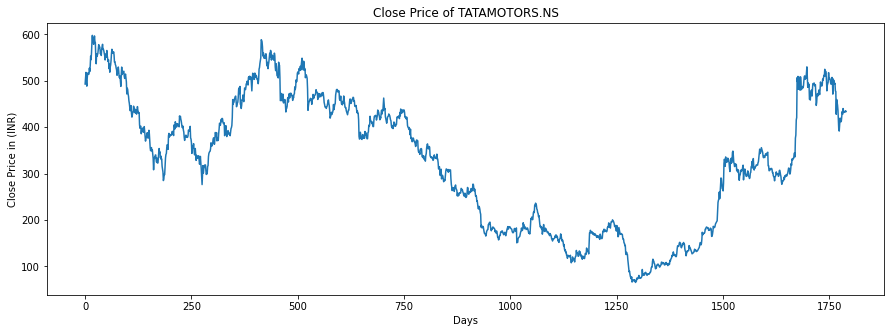

In [109]:
#Visulazing the everyday close price of the stock
plt.figure(figsize=(15,5))
plt.plot(df.Close)
plt.xlabel('Days')
plt.ylabel('Close Price in (INR)')
plt.title(f'Close Price of {Stock_name}')
plt.show()

In [49]:
#converting the data to a numpy array for faster processing
import numpy as np
Data = np.array(Data).reshape(-1,1)
Data.shape

(1789, 1)

In [50]:
#Scaling the data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
Data_scaled = scaler.fit_transform(Data)
Data_scaled

array([[0.80298939],
       [0.82777817],
       [0.85006023],
       ...,
       [0.69139682],
       [0.69505646],
       [0.69149064]])

In [51]:
#Splitting the sequential data into training and testing data
#We will use the fist 80% days of data for training and last 20% days of data for testing

train_Data = Data_scaled[:int(Data_scaled.shape[0]*0.8)]
test_Data = Data_scaled[int(Data_scaled.shape[0]*0.8):]


In [52]:
#Shape of the traaining and testing data
train_Data.shape , test_Data.shape

((1431, 1), (358, 1))

In [53]:
#Creating a function for shaping the data into X and Y for the LSTM model
def Data_shaper(dataset, SEQ_LEN):
    X, y = [], []
    for i in range(len(dataset)-SEQ_LEN-1):
        X.append(dataset[i:(i+SEQ_LEN), 0])
        y.append(dataset[i + SEQ_LEN, 0])
    return np.array(X), np.array(y)


In [54]:
#Creating the training and testing data with sequence length of 4 months (120 days) and the output of 1 day 
train_X, train_y = Data_shaper(train_Data, SEQ_LEN= 120)
test_X, test_y = Data_shaper(test_Data, SEQ_LEN= 120)

**Understanding the input data format for the LSTM model using keras documentation**<br>
<br>
``  batch_input_shape = (batch_size, timesteps, number_of_features)``

In [55]:
#Shape of the X and Y
train_X.shape , train_y.shape , test_X.shape , test_y.shape

((1310, 120), (1310,), (237, 120), (237,))

In [56]:
#reshaping the data into 3D for the LSTM model
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

In [57]:
train_X.shape , test_X.shape

((1310, 120, 1), (237, 120, 1))

### 3. Model Building

In [58]:
#Importing tensorflow and keras libraries for the LSTM model
import tensorflow as tf
#For Ignoring warnings
tf.autograph.experimental.do_not_convert
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Creating the stacked LSTM model using three hidden layes with 50 units each and dense layer at the end with tensorflow and keras API

In [110]:
#LSTM architecture with 3 hidden layers and 50 units in each hidden layer
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 120, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [62]:
#Training the LSTM model with the training data
tf.autograph.experimental.do_not_convert
model.fit(train_X, train_y, batch_size=25, epochs=100)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
53/53 [==============================] - 23s 430ms/step - loss: 0.0229
Epoch 2/100
53/53 [==============================] - 23s 430ms/step - loss: 0.0021
Epoch 3/100
53/53 [==============================] - 23s 438ms/step - loss: 0.0019
Epoch 4/100
53/53 [==============================] - 23s 428ms/step - loss: 0.0019
Epoch 5/100
53/53 [===============

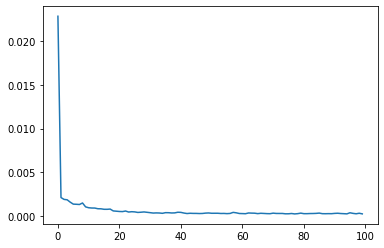

In [63]:
#Visualizing the error of the model
plt.plot(model.history.history['loss'])

In [64]:
#model prediction
Train_data_pred = model.predict(train_X)
Test_data_pred = model.predict(test_X)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### 4. Model Evaluation

Evaluating the model on train and test set data using the below metrics<br>

1. Mean square error
2. Root mean square error
3. Mean absolute error
4. R2


In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

In [66]:
#Function which takes X and y and model as arguments and returns the RMSE, MAE and R2 score
def Model_evaluation(X , y , ML_model):
    y_pred = ML_model.predict(X)
    y_true = y
    # scaling baqck to normal scale
    y_true = scaler.inverse_transform(y_true.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    Metrics = {}
    #calculating the root mean squared error
    Metrics['RMSE'] = math.sqrt(mean_squared_error(y_true, y_pred))
    #calculating the mean squared error
    Metrics['MSE'] = mean_squared_error(y_true, y_pred)
    #calculating the Mean absolute error
    Metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    #calculating the R2 score
    Metrics['R2'] = r2_score(y_true, y_pred)
    return {k : round(v,3) for k,v in Metrics.items()}

In [67]:
#evaluation of the model on the training data
Metrics_train = Model_evaluation(X = train_X, y=train_y, ML_model = model)
Metrics_train

{'RMSE': 7.971, 'MSE': 63.535, 'MAE': 5.726, 'R2': 0.997}

In [68]:
#model evaluation on the testing data
Metrics_test = Model_evaluation(X = test_X, y=test_y, ML_model = model)
Metrics_test

{'RMSE': 12.154, 'MSE': 147.722, 'MAE': 7.927, 'R2': 0.98}

Bote the train and test data have 98% Accuracy. Hence model got a good fit on the given data

**Visulazing the Model** <br>
1. On Train data
2. On Test data

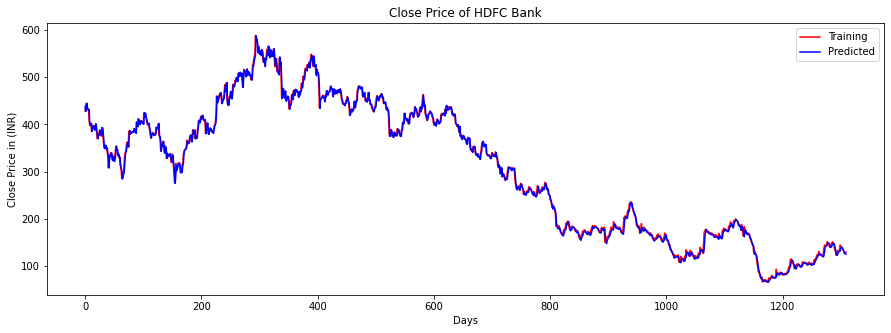

In [96]:
#visualizing the training data
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(train_y.reshape(-1,1)), color='red', label='Training')
plt.plot(scaler.inverse_transform(Train_data_pred), color='blue', label='Predicted')
plt.xlabel('Days')
plt.ylabel('Close Price in (INR)')
plt.title('Close Price of HDFC Bank')
plt.legend()
plt.show()

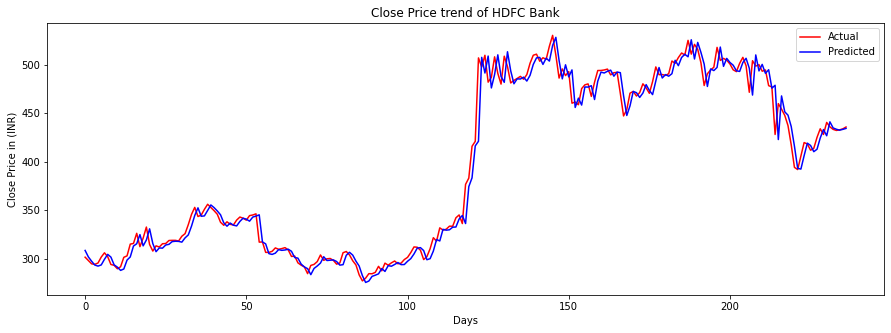

In [72]:
#visualizing the testing data
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(test_y.reshape(-1,1)), color='red', label='Actual')
plt.plot(scaler.inverse_transform(Test_data_pred), color='blue', label='Predicted')
plt.xlabel('Days')
plt.ylabel('Close Price in (INR)')
plt.title('Close Price trend of HDFC Bank')
plt.legend()
plt.show()

### 5. Predicting the Next 30 days trend

In [97]:
#Predicting next 30 days trend
Input_sequence = test_Data[-120:]
Input_sequence = Input_sequence.flatten().tolist()
for i in range(30):
    Input_sequence.extend(model.predict(np.array(Input_sequence[-120:]).reshape(-1,120,1)).flatten().tolist())


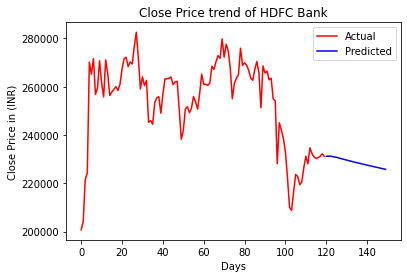

In [99]:
first = np.arange(120)
second = np.arange(120,150)
Input_sequence = scaler.inverse_transform(np.array(Input_sequence).reshape(-1,1))
plt.plot(first, Input_sequence[:120], color='red', label='Last 120 days')
plt.plot(second, Input_sequence[120:], color='blue', label='Next 30 days')
plt.xlabel('Days')
plt.ylabel('Close Price in (INR)')
plt.title('Close Price trend of HDFC Bank')
plt.legend()
plt.show()

### Conclusion

LSTM model is trained and tested on last 7 years daily close price. Performance of the model is mentioned below

***1. Training Data***

    - MSE : 7.971
    - RMSE : 63.535
    - MAE: 5.726
    - R2: 0.997
    

***2. Test Data***

    - MSE : 12.154
    - RMSE : 147.722
    - MAE : 7.927
    - R2 : 0.98